# Marker Induction Model (1979)

#### Python Modules and Utility Functions

In [66]:
import numpy as np 
import random as rnd 
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider
import matplotlib.cm as cm
import random
import networkx as nx
import numpy as np
import time
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, IntSlider
import ipywidgets as widgets
%matplotlib inline


def report_progress(i,iterations,tstart):
	''' Prints to screen the model progress. 

	Parameters
	----------
	i: int 
		Current iteration of the model.

	iterations: int 
		Number of iterations set to run. 

	tstart: float 
		Time of starting the model. 
	'''
    
	progress = ((i+1)*100)/iterations
	t = time.time()
	tpassed = (t-tstart)/60
	time2go = ((tpassed/progress)*100) - tpassed

	sys.stdout.write('\r' + "{0:.3f}".format(progress) + 
                     "% completed.  Time passed: {0:.3f} mins.".format(tpassed) +  
                     "   Expected time left: {0:.3f} mins. ".format(time2go) )
	sys.stdout.flush()

## Model Parameters

In [165]:
NUM_MARKERS = 3
FRAME_RATE = 1

DECAY_CONST = 0.006 	 			# decay constant
DIFF_CONST = 0.3 					# diffusion constant
PRE_CONC_SOURCE_CONST = 100

PRE_SHEET_LEN = 20 					# N_R in paper
POST_SHEET_LEN = 20					# N_T in paper
NUM_INIT_CONTACTS = 10				# n_0 in paper
INIT_BIAS = 15						# N_L in paper
TOTAL_SYN_WEIGHT = 1
dt = 0.5
DIFF_ITERATIONS = 10
STAB_THRESH = 0.001
CONC_THRESH = 0.01 					# epsilon in paper
WEIGHT_UPDATE_CONST = 0.01			# h in paper
MEAN_SIM_CONST = 0.03				# k in paper
SPROUT_CONST = 0.01
DISCARD_CONST = 0.005	
STRONG_SYN_CONST = 0.02		

## Initialisation

#### Initialise synaptic weights

In [3]:
def gen_init_connections(cell):
	''' Creates randomised connections to cells within the postsynaptic
	chain according to the method outlined in Willshaw, von der Malsburg (1979).  

	Parameters
	----------
	cell: int 
		Position of presynaptic cell. 

	Returns
	-------
	weights: 1D Array
		Synaptic weights for each possible connection between the cell and
		postsynaptic chain.
	'''
	weights = np.zeros(PRE_SHEET_LEN)

	start = math.floor(cell*((POST_SHEET_LEN - INIT_BIAS)/PRE_SHEET_LEN)) 
	end = start + INIT_BIAS 

	if (end >POST_SHEET_LEN): 
		end = POST_SHEET_LEN+1

	connections = rnd.sample(range(start,end),NUM_INIT_CONTACTS)
	weights[connections] = TOTAL_SYN_WEIGHT/NUM_INIT_CONTACTS

	return weights


def init_syn_weights():
	''' Generates array containing initial randomised connections between
	pre and postsynaptic chain. 

	Returns
	-------
	syn_weights: 2D Array
		Initial synaptic weights between each cell in pre and postsynaptic 
		chain.	

	'''
	syn_weights = np.zeros((PRE_SHEET_LEN,POST_SHEET_LEN))
	for cell in range(0,PRE_SHEET_LEN):
		syn_weights[cell,:] = gen_init_connections(cell)
	return syn_weights

#### Initialise initial marker positions

In [4]:
def init_marker_source():
	''' Places initial marker source in presynaptic chain. Each marker source
	is positioned evenly across the presynaptic chain. 

	Returns
	-------
	pre_marker_source: 2D Array
		Source of each marker in each position of the presynaptic chain.  
	'''
	pre_marker_source = np.zeros((PRE_SHEET_LEN,NUM_MARKERS))
	pre_marker_source[1,0] = PRE_CONC_SOURCE_CONST 
	pre_marker_source[PRE_SHEET_LEN-2,NUM_MARKERS-1] = PRE_CONC_SOURCE_CONST 
	spacing = math.floor((PRE_SHEET_LEN-3)/(NUM_MARKERS-1))

	prev = 0
	m = 1
	for k in range(NUM_MARKERS-2):
		i = prev + spacing
		pre_marker_source[i,m] = PRE_CONC_SOURCE_CONST 
		prev = i
		m+=1

	return pre_marker_source

#### Collate initialised components

In [5]:
def initialise():
	''' Initialises components of the model. 

	Returns
	-------
	syn_weights: 2D Array
		Initial random synaptic weights between each cell in retina and tectum. 

	pre_conc: 2D Array
		Initial concentrations of each marker at each position in presynaptic chain.

	post_conc: 2D Array
		Initial concentrations of each marker at each pos in postsynaptic chain.

	pre_marker_source: 2D Array
		Source of each marker at each position in presynaptic chain. 

	post_marker_source: 2D Array
		Initial source of each marker at each position in postsynaptic chain. 

	'''
	syn_weights = init_syn_weights()

	pre_conc = np.zeros((PRE_SHEET_LEN,NUM_MARKERS)) 	
	post_conc = np.zeros((POST_SHEET_LEN,NUM_MARKERS))	
	
	pre_marker_source = init_marker_source()
	post_marker_source = np.zeros((POST_SHEET_LEN,NUM_MARKERS))

	return (syn_weights,pre_conc,post_conc,pre_marker_source,post_marker_source)

#### Diffuse markers in the retina

In [6]:
def update_pre_conc(conc,marker_source):
	''' Applies diffusion equation to presynaptic marker concentrations.

	Parameters
	----------
	conc: 2D Array 
		Concentration of each marker at each position in presynaptic chain.

	marker_source: 2D Array
		Source of each marker at each position in presynaptic chain.

	Returns
	-------
	conc: 2D Array
		New concentrations of each marker in each presynaptic chain position. 

	'''
	np.seterr(divide='ignore', invalid='ignore')
	conc_change = np.zeros(conc.shape)
	average_change = 1

	while(average_change > STAB_THRESH):
		conc_change[0,:] = (-DECAY_CONST)*conc[0,:] + DIFF_CONST*(conc[1,:]-conc[0,:]) + marker_source[0,:] 
		for x in range(1,PRE_SHEET_LEN-1):
			conc_change[x,:] = (-DECAY_CONST)*conc[x,:] + DIFF_CONST*(conc[(x-1),:]- 2*conc[x,:] + conc[(x+1),:]) +  marker_source[x,:]
		x = PRE_SHEET_LEN-1
		conc_change[x,:] = (-DECAY_CONST)*conc[x,:] + DIFF_CONST*(conc[(x-1),:]- conc[x,:]) + marker_source[x,:] 
	
		percent_change = np.true_divide(conc_change,conc)
		percent_change[np.isnan(percent_change)] = 0 	# sets 0/0 = 0
		average_change = np.mean(percent_change)
		conc += conc_change*dt

	np.seterr(divide='warn', invalid='warn')
	return conc

## Model Procedure

#### 1. Calculate induced markers in the tectum

In [9]:
def update_post_marker(syn_weights,norm_pre_conc):
	''' Computes source of each marker in each postsynaptic 
	cell, induced from the presynaptic chain. 

	Parameters
	----------
	syn_weights: 2D Array
		Synaptic weights between each cell in pre and postsynaptic chain. 

	norm_pre_conc: 2D Array
		Normalised concentrations of each marker in each cell of presynaptic
		chain. 

	Returns
	-------
	post_marker_source: 2D Array
		Updated source of each marker in each cell of postsynaptic chain.

	'''
	post_marker_source = np.matmul(syn_weights.T,norm_pre_conc) 
	return post_marker_source

#### 2. Update marker concentrations in tectum

In [7]:
def update_post_conc(conc, marker_source):
	''' Applies diffusion equation to postsynaptic marker concentrations.

	Parameters
	----------
	conc: 2D Array
		Concentration of each marker in each position in postsynaptic chain. 

	marker_source: 2D Array
		Source of each marker at each position in postsynaptic chain. 

	Returns
	-------
	conc: 2D Array
		Updated concentrations of each marker after diffusion across 
		neighbouring cells. 
	'''
	conc_change = np.zeros(conc.shape)
	for i in range(DIFF_ITERATIONS):
		conc_change[0,:] = -DECAY_CONST*conc[0,:] + DIFF_CONST*(-conc[0,:] + conc[1,:]) + marker_source[0,:] 
		for x in range(1,POST_SHEET_LEN-1):
			conc_change[x,:] = - DECAY_CONST*conc[x,:] + DIFF_CONST*(conc[(x-1),:]- 2*conc[x,:] + conc[(x+1),:]) +  marker_source[x,:]
		x = PRE_SHEET_LEN-1
		conc_change[x,:] = -DECAY_CONST*conc[x,:] + DIFF_CONST*(conc[(x-1),:]- conc[x,:]) + marker_source[x,:] 
	conc += conc_change*dt
	return conc

#### 3. Normalise tectal marker concentrations

In [8]:
def norm_conc(conc,length):
	''' Normalises marker concentrations and elimnates markers 
	with sub-threshold concentrations. 

	Parameters
	----------
	conc: 2D Array
		Marker concentrations in each cell of the pre/postsynaptic chain. 

	length: int 
		Used to specify whether the pre or postsynaptic marker concentrations
		are being passed to the function, and are to be normalised. 

	Returns
	-------
	norm_conc: 2D Array
		Normalised concentrations of each marker in pre or postsynaptic chain. 

	'''
	norm_conc = np.zeros(conc.shape)
	for x in range(0,length):
		denom = np.sum(conc[x,:])
		if(denom ==0):
			norm_conc[x,:] = 0
		else:
			norm_conc[x,:] = conc[x,:]/denom

	norm_conc[norm_conc < CONC_THRESH] = 0
	return norm_conc

#### 4. Compute similarity between retinal and tectal cells

In [10]:
def calc_similarity(pre_conc,post_conc,x,y):
	''' Calculates the similarity between between two given cells. 
	See Willshaw, von der Malsburg (1979) for definition of similarity.

	Note: Pre and postsynaptic concentrations are normalised within the 
	function so no need to pass in normalised values. 

	Parameters
	----------
	pre_conc: 2D Array
		Concentration of each marker at each presynaptic chain position. 

	post_conc: 2D Array
		Concentration of each marker at each postsynaptic chain position. 

	x: int 
		Position of presynaptic cell. 

	y: int 
		Position of postsynaptic cell. 

	Returns
	-------
	similarity: int 
		Similarity of the two cells.  
	'''
	pre_molecules = np.nonzero(pre_conc[x,:])	
	post_molecules = np.nonzero(post_conc[y,:])
	common_molecules = np.intersect1d(pre_molecules,post_molecules)

	denom = np.sum(pre_conc[x,common_molecules])
	if(denom == 0):
		norm_pre = np.zeros((pre_conc[x,:].shape))
	else:
		norm_pre = pre_conc[x,:]/denom

	denom = np.sum(post_conc[y,common_molecules])
	if(denom ==0):
		norm_post = np.zeros((post_conc[y,:].shape))
	else:
		norm_post = post_conc[y,:]/denom

	norm_pre[norm_pre < CONC_THRESH] = 0
	norm_post[norm_post < CONC_THRESH] = 0

	mat = np.matrix((norm_pre,norm_post))
	similarity = np.sum(np.amin(mat,axis=0))

	return similarity

#### 5. Update synaptic weights

In [11]:
def update_weights(syn_weights,pre_conc,post_conc):
	''' Updates synaptic weights as a function of the similarity between
	each pre and postsynaptic cell. 

	Parameters
	----------
	syn_weights: 2D Array
		Synaptic weights between each cell in pre and postsynaptic chain. 

	pre_conc: 2D Array
		Concentration of each marker in each cell of the presynaptic chain.

	post_conc: 2D Array
		Concentration of each marker in each cell of the postsynaptic chain.

	Returns
	-------
	syn_weights: 2D Array
		Updated synaptic weights after adjusting for marker similarities in 
		pre and postsynaptic chain. 

	'''
	weight_change = np.zeros(syn_weights.shape)

	for x in range(0,PRE_SHEET_LEN):
		sim = np.zeros(POST_SHEET_LEN)
		for y in range(0,POST_SHEET_LEN):
			sim[y] = calc_similarity(pre_conc,post_conc,x,y)

		(connections,) = np.nonzero(syn_weights[x,:])
		mean_sim = (np.sum(sim[connections])/len(connections)) - MEAN_SIM_CONST
		weight_change[x,:] = WEIGHT_UPDATE_CONST*(sim - mean_sim)
		syn_weights[x,:] += weight_change[x,:]

	syn_weights = norm_weights(syn_weights)

	return syn_weights

#### 6. Normalise synaptic weights

In [12]:
def norm_weights(syn_weights):
	''' Normalises synaptic weights so that total weight available to 
	each fibre is constant. 

	Parameters
	----------
	syn_weights: 2D Array
		Synaptic weights between each cell in pre and postsynaptic chain. 

	Returns
	-------
	syn_weights: 2D Array
		Updated, normalised synaptic weights. 
	'''
	for j in range(POST_SHEET_LEN):
		syn_weights[:,j] = TOTAL_SYN_WEIGHT*syn_weights[:,j]/np.sum(syn_weights[:,j])
	return syn_weights

#### 7. Update synapses

In [60]:
# Removes weak synapses and creates new connections 
def update_connections(syn_weights):
	''' Removes weak synapses and creates new connections adjacent
	to strong synapses. 

	Parameters
	----------
	syn_weights: 2D Array
		Synaptic weights between each cell in pre and postsynaptic chain. 

	Returns
	-------
	new_weights: 2D Array
		Normalised synaptic weights after removal and addition of synapses. 

	'''
	syn_weights[syn_weights < (DISCARD_CONST*TOTAL_SYN_WEIGHT)] = 0
	(xinds,yinds) = np.where(syn_weights > (STRONG_SYN_CONST*TOTAL_SYN_WEIGHT)) # finds strong syns

	for index in range(0,len(yinds)):
		if((yinds[index]+1 < POST_SHEET_LEN)):
			if((syn_weights[(xinds[index],yinds[index]+1)]==0)):
				syn_weights[(xinds[index],yinds[index]+1)] = SPROUT_CONST*TOTAL_SYN_WEIGHT
		if(yinds[index]-1 >= 0):
			if(syn_weights[(xinds[index],yinds[index]-1)]==0):
				syn_weights[(xinds[index],yinds[index]-1)] = SPROUT_CONST*TOTAL_SYN_WEIGHT
	new_weights = norm_weights(syn_weights)
	return new_weights

## Running the Model Simulation

In [189]:
def run(iterations):
	''' Runs simulation of Marker Model and saves synaptic weight data 
	to NPY file. 

	Each simulation cycle consists of:
	1) Updating synaptic weights
	2) Adding/removing synapses
	3) Updating marker sources in postsynaptic chain
	4) Updating marker concentrations in postsynaptic chain
	
	Parameters
	----------
	iterations: int 
		Number of iterations to simulate model. 
	'''

	print("Running Marker Induction Model (1979)...")
	tstart = time.time()
	params = initialise()
	(syn_weights,pre_conc,post_conc,pre_marker_source,post_marker_source) = params
	iter_weights = np.zeros((math.floor(iterations/FRAME_RATE),PRE_SHEET_LEN,POST_SHEET_LEN))
	iter_weights[0,:,:] = syn_weights

	pre_conc = update_pre_conc(pre_conc,pre_marker_source)
	pre_conc = norm_conc(pre_conc,PRE_SHEET_LEN)

	for i in range(iterations):
		post_marker_source = update_post_marker(syn_weights,pre_conc)
		post_conc = update_post_conc(post_conc,post_marker_source)
		post_conc = norm_conc(post_conc,POST_SHEET_LEN)
		syn_weights = update_weights(syn_weights,pre_conc,post_conc)
		syn_weights = update_connections(syn_weights)

		if(i%FRAME_RATE == 0):
			iter_weights[math.floor(i/FRAME_RATE),:,:] = syn_weights
		report_progress(i,iterations,tstart)
        
	return iter_weights

In [187]:
iter_weights = run(2000)

100.000% completed.  Time passed: 1.302 mins.   Expected time left: 0.000 mins. 

## Visualing the Retinotopic Map

#### Synapse distribution Plot

In [82]:
def plot_iteration(syn_weights):
	for i in range(PRE_SHEET_LEN):
		(syns,) = np.nonzero(syn_weights[i,:])
		size = syn_weights[i,syns]*100
		plt.scatter([i+1 for j in range(len(syns))],syns+1,s=size,cmap=cm.Greys)

	plt.xlim([0,PRE_SHEET_LEN+1])
	plt.ylim([0,POST_SHEET_LEN+1])
	plt.xlabel('Presynaptic Cell Number')
	plt.ylabel('Postsynaptic Cell Number')

    
def update_dist(val):
	plt.axes().set_aspect('equal')
	val = int(val/FRAME_RATE)
	syn_weights = iter_weights[val,:,:]
	plot_iteration(syn_weights)


def plot_dist(weights):
    global iter_weights
    plt.figure()
    weights = iter_weights
    val = 0
    plot_iteration(iter_weights[val,:,:])
    
    interact(update_dist,val=IntSlider(min=0,
    max=len(iter_weights[:,0,0])*FRAME_RATE -1,
    step=1,description="Iteration: "))


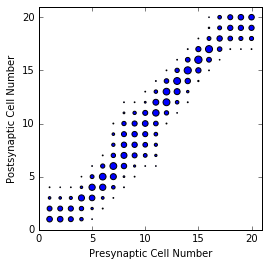

In [188]:
plot_dist(iter_weights[:,:,:])